# Data Preparation — Titanic

Tujuan:
- Menangani data kosong (hapus/isi).
- Visualisasi untuk perbandingan fitur penting.
- Mengubah output dan fitur kategorikal menjadi numerik.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
plt.style.use('ggplot')


In [2]:
# Load dataset
df = pd.read_csv('Titanic_Dataset.csv')
df.head()


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# Gambaran awal dan missing values
display(df.shape)
display(df.info())
missing_count = df.isna().sum().sort_values(ascending=False)
missing_rate = df.isna().mean().sort_values(ascending=False).round(3)
pd.DataFrame({'missing_count': missing_count, 'missing_rate': missing_rate})


(1309, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


None

,missing_count,missing_rate
body,1188,0.908
cabin,1014,0.775
boat,823,0.629
home.dest,564,0.431
age,263,0.201
embarked,2,0.002
fare,1,0.001
sibsp,0,0.000
name,0,0.000
survived,0,0.000


## Imputasi/penanganan nilai kosong
Strategi:
- age: median per (sex, pclass) lalu fallback median global.
- fare: median per pclass lalu fallback median global.
- embarked: isi dengan modus.
- cabin: buat fitur biner has_cabin, lalu drop text cabin.
- Kolom berpotensi leakage/kurang berguna: drop ['name','ticket','boat','body','home.dest'].

In [4]:
df_imputed = df.copy()

# Fitur turunan dari cabin sebelum drop
if 'cabin' in df_imputed.columns:
    df_imputed['has_cabin'] = df_imputed['cabin'].notna().astype(int)
else:
    df_imputed['has_cabin'] = 0

# Imputasi 'age' per (sex, pclass)
if {'sex','pclass','age'}.issubset(df_imputed.columns):
    age_group_med = df_imputed.groupby(['sex','pclass'])['age'].transform('median')
    df_imputed['age'] = df_imputed['age'].fillna(age_group_med)
    df_imputed['age'] = df_imputed['age'].fillna(df_imputed['age'].median())

# Imputasi 'fare' per pclass
if {'pclass','fare'}.issubset(df_imputed.columns):
    fare_group_med = df_imputed.groupby('pclass')['fare'].transform('median')
    df_imputed['fare'] = df_imputed['fare'].fillna(fare_group_med)
    df_imputed['fare'] = df_imputed['fare'].fillna(df_imputed['fare'].median())

# Imputasi 'embarked' dengan modus
if 'embarked' in df_imputed.columns and df_imputed['embarked'].isna().any():
    mode_emb = df_imputed['embarked'].mode(dropna=True)
    if not mode_emb.empty:
        df_imputed['embarked'] = df_imputed['embarked'].fillna(mode_emb.iloc[0])

# Drop kolom teks/berpotensi leakage
drop_cols = [c for c in ['name','ticket','cabin','boat','body','home.dest'] if c in df_imputed.columns]
df_imputed = df_imputed.drop(columns=drop_cols)

df_imputed.isna().sum().sort_values(ascending=False).head(10)


pclass       0
survived     0
sex          0
age          0
sibsp        0
parch        0
fare         0
embarked     0
has_cabin    0
dtype: int64

## Visualisasi perbandingan
- Rasio selamat berdasarkan jenis kelamin.
- Rasio selamat berdasarkan kelas penumpang.
- Distribusi usia berdasarkan status selamat.
- Perbandingan jumlah selamat per pelabuhan (embarked).

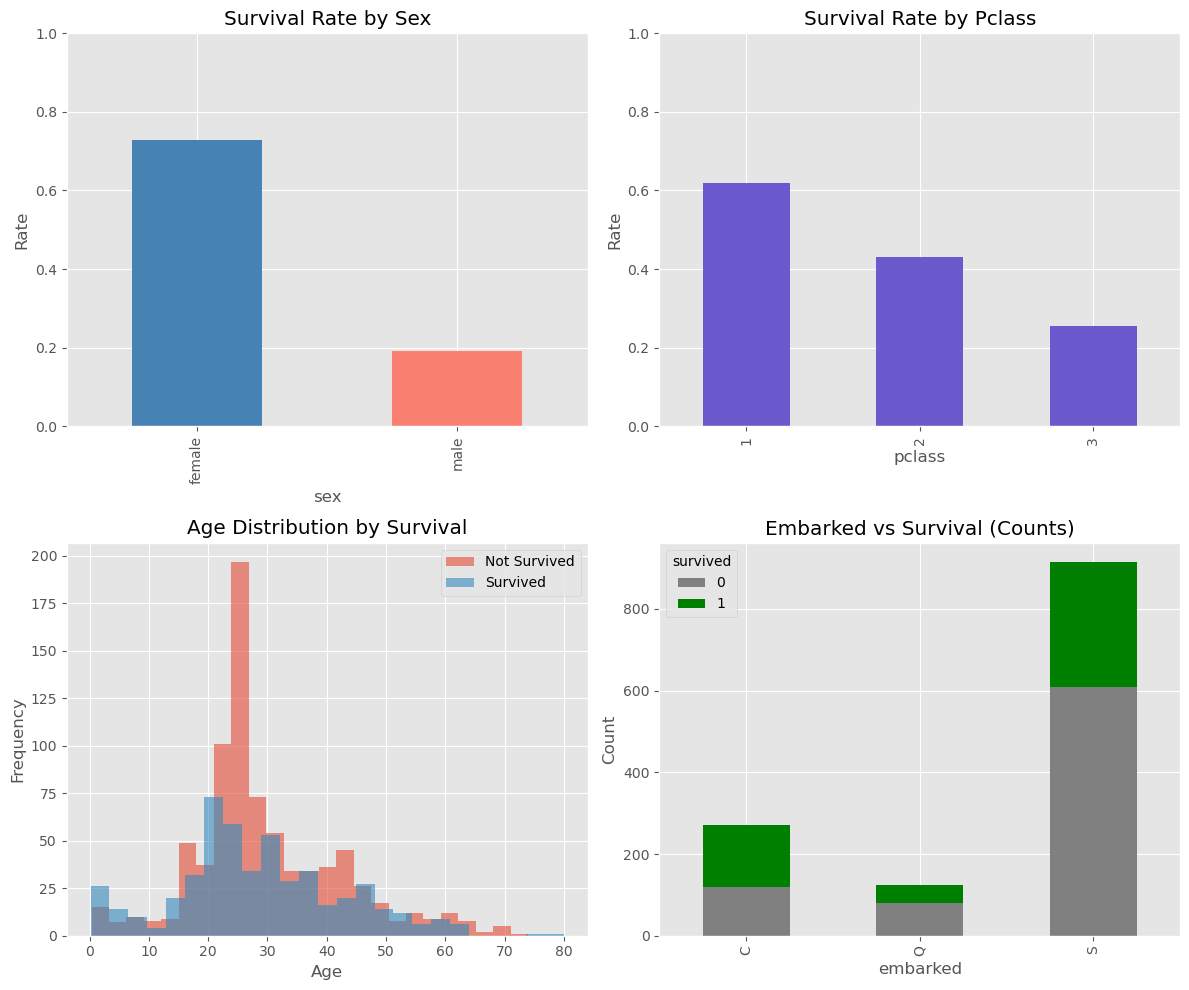

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Survival rate by sex (gunakan label asli jika masih ada)
if 'sex' in df.columns:
    rate_by_sex = df.groupby('sex')['survived'].mean()
    rate_by_sex.plot(kind='bar', ax=axes[0,0], color=['steelblue','salmon'])
    axes[0,0].set_title('Survival Rate by Sex')
    axes[0,0].set_ylabel('Rate')
    axes[0,0].set_ylim(0,1)

# Survival rate by pclass
if 'pclass' in df_imputed.columns:
    df_imputed.groupby('pclass')['survived'].mean().plot(kind='bar', ax=axes[0,1], color='slateblue')
    axes[0,1].set_title('Survival Rate by Pclass')
    axes[0,1].set_ylabel('Rate')
    axes[0,1].set_ylim(0,1)

# Age distribution by survived
if {'age','survived'}.issubset(df_imputed.columns):
    df_imputed[df_imputed['survived'] == 0]['age'].plot(kind='hist', bins=25, alpha=0.6, ax=axes[1,0], label='Not Survived')
    df_imputed[df_imputed['survived'] == 1]['age'].plot(kind='hist', bins=25, alpha=0.6, ax=axes[1,0], label='Survived')
    axes[1,0].legend()
    axes[1,0].set_title('Age Distribution by Survival')
    axes[1,0].set_xlabel('Age')

# Embarked vs survived (stacked counts)
if {'embarked','survived'}.issubset(df_imputed.columns):
    ct = pd.crosstab(df_imputed['embarked'], df_imputed['survived'])
    ct.plot(kind='bar', stacked=True, ax=axes[1,1], color=['grey','green'])
    axes[1,1].set_title('Embarked vs Survival (Counts)')
    axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()


## Encoding menjadi numerik
- Pastikan target `survived` bertipe numerik.
- Encode `sex` menjadi 0/1.
- One-hot untuk `embarked`.
- Pilih fitur numerik final untuk model.

In [7]:
df_prepared = df_imputed.copy()

# Pastikan target numerik 0/1
df_prepared['survived'] = pd.to_numeric(df_prepared['survived'], errors='coerce').fillna(0).astype(int)

# Encode sex: male=0, female=1
if 'sex' in df_prepared.columns:
    df_prepared['sex'] = df_prepared['sex'].map({'male':0, 'female':1}).astype(int)

# One-hot embarked (jika ada)
if 'embarked' in df_prepared.columns:
    df_prepared = pd.get_dummies(df_prepared, columns=['embarked'], prefix='embarked', drop_first=False)

# Pilih fitur numerik final (yang umum dipakai)
feature_candidates = [
    'pclass','sex','age','sibsp','parch','fare','has_cabin',
    'embarked_C','embarked_Q','embarked_S'
]
features = [c for c in feature_candidates if c in df_prepared.columns]

X = df_prepared[features].copy()
y = df_prepared['survived'].copy()

display(X.head())
display(X.info())
display(y.value_counts())
print('Total missing in X:', int(X.isna().sum().sum()))


,pclass,sex,age,sibsp,parch,fare,has_cabin,embarked_C,embarked_Q,embarked_S
0,1,1,29.00,0,0,211.3375,1,False,False,True
1,1,0,0.92,1,2,151.5500,1,False,False,True
2,1,1,2.00,1,2,151.5500,1,False,False,True
3,1,0,30.00,1,2,151.5500,1,False,False,True
4,1,1,25.00,1,2,151.5500,1,False,False,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   int64  
 1   sex         1309 non-null   int64  
 2   age         1309 non-null   float64
 3   sibsp       1309 non-null   int64  
 4   parch       1309 non-null   int64  
 5   fare        1309 non-null   float64
 6   has_cabin   1309 non-null   int64  
 7   embarked_C  1309 non-null   bool   
 8   embarked_Q  1309 non-null   bool   
 9   embarked_S  1309 non-null   bool   
dtypes: bool(3), float64(2), int64(5)
memory usage: 75.5 KB


None

survived
0    809
1    500
Name: count, dtype: int64

Total missing in X: 0


In [8]:
# Simpan dataset yang sudah dipreparasi
out_path = 'Titanic_prepared.csv'
df_prepared.to_csv(out_path, index=False)
out_path


'Titanic_prepared.csv'

In [9]:
!cat Titanic_prepared.csv

pclass,survived,sex,age,sibsp,parch,fare,has_cabin,embarked_C,embarked_Q,embarked_S
1,1,1,29.0,0,0,211.3375,1,False,False,True
1,1,0,0.92,1,2,151.55,1,False,False,True
1,0,1,2.0,1,2,151.55,1,False,False,True
1,0,0,30.0,1,2,151.55,1,False,False,True
1,0,1,25.0,1,2,151.55,1,False,False,True
1,1,0,48.0,0,0,26.55,1,False,False,True
1,1,1,63.0,1,0,77.9583,1,False,False,True
1,0,0,39.0,0,0,0.0,1,False,False,True
1,1,1,53.0,2,0,51.4792,1,False,False,True
1,0,0,71.0,0,0,49.5042,0,True,False,False
1,0,0,47.0,1,0,227.525,1,True,False,False
1,1,1,18.0,1,0,227.525,1,True,False,False
1,1,1,24.0,0,0,69.3,1,True,False,False
1,1,1,26.0,0,0,78.85,0,False,False,True
1,1,0,80.0,0,0,30.0,1,False,False,True
1,0,0,42.0,0,0,25.925,0,False,False,True
1,0,0,24.0,0,1,247.5208,1,True,False,False
1,1,1,50.0,0,1,247.5208,1,True,False,False
1,1,1,32.0,0,0,76.2917,1,True,False,False
1,0,0,36.0,0,0,75.2417,1,True,False,False
1,1,0,37.0,1,1,52.5542,1,False,False,True
1,1,1,47.0,1,1,52.5542,1,False,False,True
1,1,0,26.